In [1]:
from dataclasses import dataclass
from typing import Dict, Any, List
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

@dataclass
class ExperimentConfig:
    """Configuration for consistent experiments"""
    random_state: int = 42
    test_size: float = 0.2
    use_smote: bool = True
    cv_folds: int = 5
    scoring_metrics: List[str] = None
    feature_groups: Dict[str, bool] = None
    
    def __post_init__(self):
        if self.scoring_metrics is None:
            self.scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
        
        if self.feature_groups is None:
            self.feature_groups = {
                'stadium': True,
                'weather': True,
                'play_type': True,
                'position_group': True,
                'position': True,
                'roster': True
            }

class NFLInjuryPreprocessor:
    def __init__(self, use_smote=True, random_state=42, test_size=0.2):
        self.use_smote = use_smote
        self.random_state = random_state
        self.test_size = test_size
        self.preprocessor = None
        self.pipeline = None
        self.feature_names = None
        
    def create_pipeline(self, X):
        """Create preprocessing pipeline - NO SCALING in preprocessor"""
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('passthrough', 'passthrough', X.select_dtypes(include=[np.number]).columns)
            ],
            remainder='passthrough'
        )
        
        if self.use_smote:
            self.pipeline = ImbPipeline([
                ('preprocessor', self.preprocessor),
                ('smote', SMOTE(random_state=self.random_state)),
                ('scaler', StandardScaler())  # Scale ONCE after SMOTE
            ])
        else:
            self.pipeline = Pipeline([
                ('preprocessor', self.preprocessor),
                ('scaler', StandardScaler())
            ])
    
    def split_and_preprocess(self, X, y):
        """Split data and apply preprocessing consistently"""
        # Split first
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=self.test_size, 
            random_state=self.random_state, 
            stratify=y
        )
        
        # Create pipeline
        self.create_pipeline(X)
        
        # Process training data
        if self.use_smote:
            X_train_processed, y_train_processed = self.pipeline[:-1].fit_resample(X_train, y_train)
            X_train_final = self.pipeline[-1].fit_transform(X_train_processed)
        else:
            X_train_final = self.pipeline.fit_transform(X_train)
            y_train_processed = y_train
        
        # Process test data (no SMOTE, same scaler)
        if self.use_smote:
            X_test_preprocessed = self.pipeline[:-2].transform(X_test)  # Just preprocessor
            X_test_final = self.pipeline[-1].transform(X_test_preprocessed)  # Apply same scaler
        else:
            X_test_final = self.pipeline.transform(X_test)
        
        # Store feature names for later use
        self.feature_names = X.columns.tolist()
        
        return X_train_final, X_test_final, y_train_processed, y_test

def apply_feature_selection(df, config):
    """Apply feature selection based on config"""
    columns_to_drop = []
    
    if not config.feature_groups['stadium']:
        columns_to_drop.extend([col for col in df.columns if 'Stadium' in col])
    if not config.feature_groups['weather']:
        columns_to_drop.extend([col for col in df.columns if 'Weather' in col])
    if not config.feature_groups['play_type']:
        columns_to_drop.extend([col for col in df.columns if 'PlayType' in col])
    if not config.feature_groups['position_group']:
        columns_to_drop.extend([col for col in df.columns if 'PositionGroup' in col])
    if not config.feature_groups['position']:
        columns_to_drop.extend([col for col in df.columns if 'Position' in col])
    if not config.feature_groups['roster']:
        columns_to_drop.extend([col for col in df.columns if 'Roster' in col])
    
    return df.drop(columns=columns_to_drop, errors='ignore')

class NFLExperiment:
    def __init__(self, config: ExperimentConfig):
        self.config = config
        self.preprocessor = NFLInjuryPreprocessor(
            use_smote=config.use_smote,
            random_state=config.random_state,
            test_size=config.test_size
        )
        self.results = {}
        self.X_train_final = None
        self.X_test_final = None
        self.y_train_processed = None
        self.y_test = None
    
    def prepare_data(self, df):
        """Prepare data once for all experiments"""
        # Data cleaning (your existing code)
        df[df.select_dtypes('bool').columns] = df.select_dtypes('bool').astype(int)
        df['Injury'] = (df['Injury'] > 0).astype(int)
        df['Temperature'] = df['Temperature'].replace(-999, df['Temperature'].mean())
        df['Temperature'] = df['Temperature'].replace(-35.04415537718783, df['Temperature'].mean())
        df = df[~((df.drop(columns=['Injury']) == 0.0).all(axis=1))]
        
        # Drop leakage columns
        injury_days = ['DM_M1', 'DM_M7', 'DM_M28', 'DM_M42']
        df = df.drop(columns=injury_days, errors='ignore')
        
        # Apply feature selection
        df_processed = apply_feature_selection(df, self.config)
        
        # Prepare data
        X = df_processed.drop(columns=['Injury'])
        y = df_processed['Injury']
        
        # Preprocess once
        self.X_train_final, self.X_test_final, self.y_train_processed, self.y_test = \
            self.preprocessor.split_and_preprocess(X, y)
        
        print(f"Original training set: {pd.Series(self.y_test).value_counts().sort_index()}")
        print(f"After SMOTE: {pd.Series(self.y_train_processed).value_counts().sort_index()}")
        print(f"Training shape: {self.X_train_final.shape}")
        print(f"Test shape: {self.X_test_final.shape}")
        
        return self
    
    def run_experiment(self, model, model_name, **model_params):
        """Run a complete experiment with a given model"""
        if self.X_train_final is None:
            raise ValueError("Must call prepare_data() first!")
        
        # Train model
        if hasattr(model, 'random_state'):
            model.set_params(random_state=self.config.random_state, **model_params)
        else:
            model.set_params(**model_params)
        
        model.fit(self.X_train_final, self.y_train_processed)
        
        # Evaluate
        results = self.evaluate_model(model, self.X_train_final, self.X_test_final, 
                                    self.y_train_processed, self.y_test, model_name)
        self.results[model_name] = results
        
        return results
    
    def evaluate_model(self, model, X_train, X_test, y_train, y_test, model_name):
        """Consistent evaluation across all models"""
        from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
        
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
        
        # Calculate minority class accuracy
        class_1_mask = (y_test == 1)
        class_1_predictions = y_pred[class_1_mask]
        class_1_actual = y_test[class_1_mask]
        
        minority_class_accuracy = 0.0
        if len(class_1_actual) > 0:
            minority_class_accuracy = accuracy_score(class_1_actual, class_1_predictions)
        
        results = {
            'model_name': model_name,
            'classification_report': classification_report(y_test, y_pred, output_dict=True),
            'confusion_matrix': confusion_matrix(y_test, y_pred).tolist(),
            'train_score': model.score(X_train, y_train),
            'test_score': model.score(X_test, y_test),
            'minority_class_accuracy': minority_class_accuracy
        }
        
        if y_pred_proba is not None:
            results['roc_auc'] = roc_auc_score(y_test, y_pred_proba)
        
        return results

# Load and prepare data
df = pd.read_csv('/Users/petershmorhun/Documents/GitHub/summer_milestone_2/datasets/nfl-playing-surface-analytics/motion_df_encoded.csv')

# Set up experiment configuration
config = ExperimentConfig(
    random_state=42,
    use_smote=True,
    test_size=0.2,
    feature_groups={
        'stadium': False,
        'weather': False,
        'play_type': False,
        'position_group': False,
        'position': False,
        'roster': False
    }
)

# Create experiment instance and prepare data
experiment = NFLExperiment(config)
experiment.prepare_data(df)

# Store the processed data for backward compatibility with your existing code
X_train_final = experiment.X_train_final
X_test_final = experiment.X_test_final
y_train_processed = experiment.y_train_processed
y_test = experiment.y_test

Original training set: Injury
0    53377
1       21
Name: count, dtype: int64
After SMOTE: Injury
0    213507
1    213507
Name: count, dtype: int64
Training shape: (427014, 19)
Test shape: (53398, 19)


In [8]:
config.feature_names = experiment.preprocessor.feature_names

In [9]:
print(config.feature_names)  # Print feature names for verification

['PlayerDay', 'PlayerGame', 'Temperature', 'PlayerGamePlay', 'time_max', 'dir_max', 'dis_max', 'o_max', 's_max', 'angle_max', 'time_avg', 'dir_avg', 'dis_avg', 'o_avg', 's_avg', 'angle_avg', 'FieldType_Natural', 'FieldType_Synthetic', 'FieldType_nan']


In [5]:
X_train_final_df = pd.DataFrame(X_train_final)

In [7]:
X_train_final_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,1.609675,1.295807,-0.467538,0.504468,0.753432,0.452111,0.536676,0.557031,0.746297,0.959855,0.755137,1.077235,-0.045273,1.373014,-0.025772,0.664707,1.164322,-0.873782,0.0
1,-0.432359,0.103397,-0.236796,1.985815,0.520238,0.441965,-0.752773,0.550976,-0.770053,-0.038192,0.521715,0.514411,-0.633404,0.599478,-0.711243,0.226949,-0.973546,1.302850,0.0
2,1.253309,1.057325,0.301603,0.913115,0.928328,0.450753,1.575399,0.552012,0.267450,-0.967268,0.924496,0.170259,0.294585,-0.758401,0.295300,-1.465784,1.164322,-0.873782,0.0
3,-0.409732,0.103397,0.570802,-0.619313,0.877317,0.432618,-0.000594,0.555597,-0.257002,0.785219,0.879143,0.016131,-0.573926,1.161738,-0.628174,1.847757,1.164322,-0.873782,0.0
4,-0.488925,-0.015844,-0.198339,1.117439,0.345342,0.447637,-0.824409,0.554880,-0.701646,0.961980,0.346647,0.124136,-0.764684,-0.353723,-0.711361,-0.747858,1.164322,-0.873782,0.0


Accuracy: 0.993651
Precision: 0.015244
Recall: 0.238095
F1 Score: 0.028653
ROC AUC: 0.615051
Minority Class Accuracy: 0.238095

Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     53377
           1       0.02      0.24      0.03        21

    accuracy                           0.99     53398
   macro avg       0.51      0.62      0.51     53398
weighted avg       1.00      0.99      1.00     53398



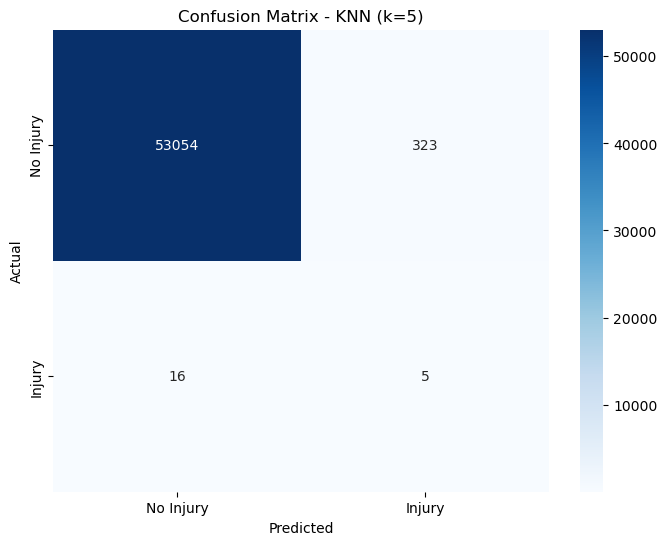

In [3]:
# Test with initial KNN using the experiment framework
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Run experiment using the framework
results = experiment.run_experiment(
    model=KNeighborsClassifier(n_jobs=-1),
    model_name='KNN_initial',
    n_neighbors=5
)

# Display results
print(f"Accuracy: {results['test_score']:.6f}")
print(f"Precision: {results['classification_report']['1']['precision']:.6f}")
print(f"Recall: {results['classification_report']['1']['recall']:.6f}")
print(f"F1 Score: {results['classification_report']['1']['f1-score']:.6f}")
if 'roc_auc' in results:
    print(f"ROC AUC: {results['roc_auc']:.6f}")
print(f"Minority Class Accuracy: {results['minority_class_accuracy']:.6f}")

# Print classification report
from sklearn.metrics import classification_report
neigh = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
neigh.fit(X_train_final, y_train_processed)
y_pred = neigh.predict(X_test_final)
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Injury', 'Injury'], 
            yticklabels=['No Injury', 'Injury'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - KNN (k=5)')
plt.show()

Tuning K-Neighbors hyperparameter...


Tuning KNN k-neighbors:  11%|█         | 1/9 [00:29<03:52, 29.06s/it]

k= 1 | Minority Acc: 0.1905 | Overall Acc: 0.9972 | F1: 0.0500


Tuning KNN k-neighbors:  22%|██▏       | 2/9 [00:58<03:26, 29.49s/it]

k= 2 | Minority Acc: 0.1905 | Overall Acc: 0.9972 | F1: 0.0500


Tuning KNN k-neighbors:  33%|███▎      | 3/9 [01:27<02:55, 29.33s/it]

k= 3 | Minority Acc: 0.1905 | Overall Acc: 0.9955 | F1: 0.0321


Tuning KNN k-neighbors:  44%|████▍     | 4/9 [01:57<02:26, 29.38s/it]

k= 4 | Minority Acc: 0.1905 | Overall Acc: 0.9955 | F1: 0.0321


Tuning KNN k-neighbors:  56%|█████▌    | 5/9 [02:26<01:57, 29.38s/it]

k= 5 | Minority Acc: 0.2381 | Overall Acc: 0.9937 | F1: 0.0287


Tuning KNN k-neighbors:  67%|██████▋   | 6/9 [02:55<01:27, 29.28s/it]

k= 6 | Minority Acc: 0.2381 | Overall Acc: 0.9937 | F1: 0.0287


Tuning KNN k-neighbors:  78%|███████▊  | 7/9 [03:25<00:58, 29.30s/it]

k= 7 | Minority Acc: 0.2381 | Overall Acc: 0.9921 | F1: 0.0231


Tuning KNN k-neighbors:  89%|████████▉ | 8/9 [03:54<00:29, 29.30s/it]

k= 8 | Minority Acc: 0.2381 | Overall Acc: 0.9921 | F1: 0.0231


Tuning KNN k-neighbors: 100%|██████████| 9/9 [04:23<00:00, 29.30s/it]

k= 9 | Minority Acc: 0.2381 | Overall Acc: 0.9905 | F1: 0.0193

Best k-neighbors: 5
Best minority class accuracy: 0.2381


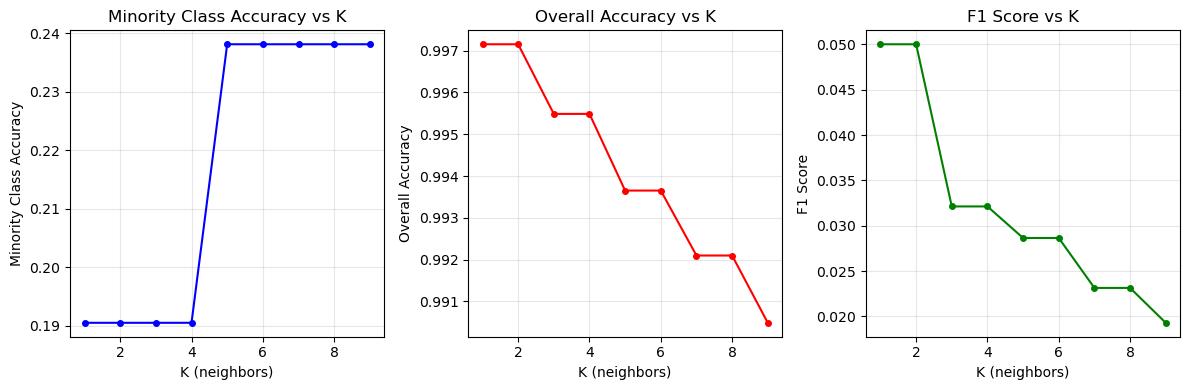

In [22]:
# Model tuning for k-neighbors using the framework
n_neighbors_range = range(1, 10)
best_score = 0
best_n_neighbors = 0
tuning_results = {}

print("Tuning K-Neighbors hyperparameter...")
print("=" * 50)

for n_neighbors in tqdm(n_neighbors_range, desc="Tuning KNN k-neighbors"):
    # Run experiment for this k value
    results = experiment.run_experiment(
        model=KNeighborsClassifier(n_jobs=-1),
        model_name=f'KNN_k_{n_neighbors}',
        n_neighbors=n_neighbors
    )
    
    minority_class_accuracy = results['minority_class_accuracy']
    tuning_results[n_neighbors] = {
        'minority_class_accuracy': minority_class_accuracy,
        'overall_accuracy': results['test_score'],
        'roc_auc': results.get('roc_auc', 0.0),
        'f1_score': results['classification_report']['1']['f1-score']
    }
    
    if minority_class_accuracy > best_score:
        best_score = minority_class_accuracy
        best_n_neighbors = n_neighbors
    
    print(f"k={n_neighbors:2d} | Minority Acc: {minority_class_accuracy:.4f} | "
          f"Overall Acc: {results['test_score']:.4f} | F1: {tuning_results[n_neighbors]['f1_score']:.4f}")

print("\n" + "=" * 50)
print(f"Best k-neighbors: {best_n_neighbors}")
print(f"Best minority class accuracy: {best_score:.4f}")
print("=" * 50)

# Plot tuning results
import matplotlib.pyplot as plt

k_values = list(tuning_results.keys())
minority_accs = [tuning_results[k]['minority_class_accuracy'] for k in k_values]
overall_accs = [tuning_results[k]['overall_accuracy'] for k in k_values]
f1_scores = [tuning_results[k]['f1_score'] for k in k_values]

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(k_values, minority_accs, 'b-o', markersize=4)
plt.title('Minority Class Accuracy vs K')
plt.xlabel('K (neighbors)')
plt.ylabel('Minority Class Accuracy')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(k_values, overall_accs, 'r-o', markersize=4)
plt.title('Overall Accuracy vs K')
plt.xlabel('K (neighbors)')
plt.ylabel('Overall Accuracy')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(k_values, f1_scores, 'g-o', markersize=4)
plt.title('F1 Score vs K')
plt.xlabel('K (neighbors)')
plt.ylabel('F1 Score')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [23]:
# Algorithm tuning using the framework
algorithm_options = ['ball_tree', 'kd_tree', 'brute']
best_score = 0
best_algorithm = ''
algorithm_results = {}

print("Tuning KNN Algorithm...")
print("=" * 50)

for algorithm in tqdm(algorithm_options, desc="Tuning KNN algorithm"):
    # Run experiment for this algorithm
    results = experiment.run_experiment(
        model=KNeighborsClassifier(n_jobs=-1),
        model_name=f'KNN_{algorithm}',
        n_neighbors=best_n_neighbors,  # Use the best k from previous tuning
        algorithm=algorithm
    )
    
    minority_class_accuracy = results['minority_class_accuracy']
    algorithm_results[algorithm] = {
        'minority_class_accuracy': minority_class_accuracy,
        'overall_accuracy': results['test_score'],
        'roc_auc': results.get('roc_auc', 0.0),
        'f1_score': results['classification_report']['1']['f1-score']
    }
    
    if minority_class_accuracy > best_score:
        best_score = minority_class_accuracy
        best_algorithm = algorithm
    
    print(f"Algorithm: {algorithm:10s} | Minority Acc: {minority_class_accuracy:.4f} | "
          f"Overall Acc: {results['test_score']:.4f} | F1: {algorithm_results[algorithm]['f1_score']:.4f}")

print("\n" + "=" * 50)
print(f"Best algorithm: '{best_algorithm}'")
print(f"Best minority class accuracy: {best_score:.4f}")
print(f"Using k-neighbors: {best_n_neighbors}")
print("=" * 50)

# Create final optimized model
final_knn = KNeighborsClassifier(
    n_neighbors=best_n_neighbors,
    algorithm=best_algorithm,
    n_jobs=-1
)

final_results = experiment.run_experiment(
    model=final_knn,
    model_name='KNN_final_optimized',
    n_neighbors=best_n_neighbors,
    algorithm=best_algorithm
)

print(f"\nFinal Optimized KNN Results:")
print(f"- K-neighbors: {best_n_neighbors}")
print(f"- Algorithm: {best_algorithm}")
print(f"- Minority Class Accuracy: {final_results['minority_class_accuracy']:.4f}")
print(f"- Overall Accuracy: {final_results['test_score']:.4f}")
print(f"- F1 Score: {final_results['classification_report']['1']['f1-score']:.4f}")
if 'roc_auc' in final_results:
    print(f"- ROC AUC: {final_results['roc_auc']:.4f}")

# Store the optimized parameters for other experiments
optimized_knn_params = {
    'n_neighbors': best_n_neighbors,
    'algorithm': best_algorithm
}

Tuning KNN Algorithm...


Tuning KNN algorithm:  33%|███▎      | 1/3 [11:06<22:12, 666.16s/it]

Algorithm: ball_tree  | Minority Acc: 0.2381 | Overall Acc: 0.9937 | F1: 0.0287


Tuning KNN algorithm:  67%|██████▋   | 2/3 [12:11<05:12, 312.49s/it]

Algorithm: kd_tree    | Minority Acc: 0.2381 | Overall Acc: 0.9937 | F1: 0.0287


Tuning KNN algorithm: 100%|██████████| 3/3 [12:41<00:00, 253.76s/it]

Algorithm: brute      | Minority Acc: 0.2381 | Overall Acc: 0.9937 | F1: 0.0287

Best algorithm: 'ball_tree'
Best minority class accuracy: 0.2381
Using k-neighbors: 5



Final Optimized KNN Results:
- K-neighbors: 5
- Algorithm: ball_tree
- Minority Class Accuracy: 0.2381
- Overall Accuracy: 0.9937
- F1 Score: 0.0287
- ROC AUC: 0.6151


In [ ]:
# Algorithm tuning using the framework
weights_options = ['uniform', 'distance']
best_score = 0
best_weight = ''
weight_results = {}

print("Tuning KNN Weight...")
print("=" * 50)

for weight in tqdm(weights_options, desc="Tuning KNN weight"):
    # Run experiment for this weight
    results = experiment.run_experiment(
        model=KNeighborsClassifier(n_jobs=-1),
        model_name=f'KNN_{weight}',
        n_neighbors=best_n_neighbors,  # Use the best k from previous tuning
        algorithm=algorithm,
        weights=weight
    )
    
    minority_class_accuracy = results['minority_class_accuracy']
    algorithm_results[algorithm] = {
        'minority_class_accuracy': minority_class_accuracy,
        'overall_accuracy': results['test_score'],
        'roc_auc': results.get('roc_auc', 0.0),
        'f1_score': results['classification_report']['1']['f1-score']
    }
    
    if minority_class_accuracy > best_score:
        best_score = minority_class_accuracy
        best_algorithm = algorithm
        best_weight = weight
    
    print(f"Algorithm: {algorithm:10s} | Minority Acc: {minority_class_accuracy:.4f} | "
          f"Overall Acc: {results['test_score']:.4f} | F1: {algorithm_results[algorithm]['f1_score']:.4f}")

print("\n" + "=" * 50) 
print(f"Best algorithm: '{best_algorithm}'")
print(f"Best minority class accuracy: {best_score:.4f}")
print(f"Using k-neighbors: {best_n_neighbors}")
print(f"Using weights: {best_weight}")
print("=" * 50)

# Create final optimized model
final_knn = KNeighborsClassifier(
    n_neighbors=best_n_neighbors,
    algorithm=best_algorithm,
    weights=best_weight,
    n_jobs=-1
)

final_results = experiment.run_experiment(
    model=final_knn,
    model_name='KNN_final_optimized',
    n_neighbors=best_n_neighbors,
    algorithm=best_algorithm,
    weights=best_weight
    
)

print(f"\nFinal Optimized KNN Results:")
print(f"- K-neighbors: {best_n_neighbors}")
print(f"- Algorithm: {best_algorithm}")
print(f"- Minority Class Accuracy: {final_results['minority_class_accuracy']:.4f}")
print(f"- Overall Accuracy: {final_results['test_score']:.4f}")
print(f"- F1 Score: {final_results['classification_report']['1']['f1-score']:.4f}")
if 'roc_auc' in final_results:
    print(f"- ROC AUC: {final_results['roc_auc']:.4f}")

# Store the optimized parameters for other experiments
optimized_knn_params = {
    'n_neighbors': best_n_neighbors,
    'algorithm': best_algorithm,
    'weights': weights_options
}

Tuning KNN Weight...


Tuning KNN weight:  50%|█████     | 1/2 [00:29<00:29, 29.89s/it]

Algorithm: brute      | Minority Acc: 0.2381 | Overall Acc: 0.9937 | F1: 0.0287


Tuning KNN weight: 100%|██████████| 2/2 [00:58<00:00, 29.05s/it]

Algorithm: brute      | Minority Acc: 0.2381 | Overall Acc: 0.9937 | F1: 0.0287

Best algorithm: 'brute'
Best minority class accuracy: 0.2381
Using k-neighbors: 5
Using weights: uniform



Final Optimized KNN Results:
- K-neighbors: 5
- Algorithm: brute
- Minority Class Accuracy: 0.2381
- Overall Accuracy: 0.9937
- F1 Score: 0.0287
- ROC AUC: 0.6151


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tqdm import tqdm
import time

def run_classifier_model(model, X_train, y_train, X_test, y_test, 
                        scoring='accuracy', n_repeats=5, n_jobs=-1, **model_params):
    """
    Run a classifier model with cross-validation
    
    Parameters:
    -----------
    model : sklearn classifier class or instance
    X_train, y_train, X_test, y_test : training and test data
    scoring : str, scoring metric for CV ('accuracy', 'precision', 'recall', 'f1', 'roc_auc')
    n_repeats : int, number of CV repeats
    n_jobs : int, parallel jobs
    **model_params : additional model parameters
    
    Returns:
    --------
    tuple: (mean_cv_score, std_cv_score, train_score, test_score)
    """
    
    # Instantiate the model if a class is provided
    if isinstance(model, type):
        model = model(**model_params)
    
    # Use StratifiedKFold for classification to maintain class balance
    cv_scores = cross_val_score(
        model, X_train, y_train,
        scoring=scoring,
        cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=n_repeats, random_state=42),
        n_jobs=n_jobs
    )
    
    mean_cv_score = np.mean(cv_scores)
    std_cv_score = np.std(cv_scores)
    
    # Fit the model on the full training set
    model.fit(X_train, y_train)
    
    # Compute training and testing scores
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    # Calculate the appropriate metric
    if scoring == 'accuracy':
        train_score = accuracy_score(y_train, train_preds)
        test_score = accuracy_score(y_test, test_preds)
    elif scoring == 'precision':
        train_score = precision_score(y_train, train_preds, average='binary')
        test_score = precision_score(y_test, test_preds, average='binary')
    elif scoring == 'recall':
        train_score = recall_score(y_train, train_preds, average='binary')
        test_score = recall_score(y_test, test_preds, average='binary')
    elif scoring == 'f1':
        train_score = f1_score(y_train, train_preds, average='binary')
        test_score = f1_score(y_test, test_preds, average='binary')
    elif scoring == 'roc_auc':
        # For ROC-AUC, we need probabilities
        if hasattr(model, 'predict_proba'):
            train_probs = model.predict_proba(X_train)[:, 1]
            test_probs = model.predict_proba(X_test)[:, 1]
            train_score = roc_auc_score(y_train, train_probs)
            test_score = roc_auc_score(y_test, test_probs)
        else:
            # Fallback to decision function or predictions
            train_score = roc_auc_score(y_train, train_preds)
            test_score = roc_auc_score(y_test, test_preds)
    else:
        # Default to accuracy
        train_score = accuracy_score(y_train, train_preds)
        test_score = accuracy_score(y_test, test_preds)
    
    return mean_cv_score, std_cv_score, train_score, test_score

def sweep_classifier_parameter(model,
                              Parameters,
                              param,
                              parameter_list,
                              X_train,
                              y_train,
                              X_test,
                              y_test,
                              scoring='accuracy',
                              verbose=True,
                              n_iter_no_change=None,
                              delta=0.001,
                              n_jobs=-1,
                              n_repeats=5):
    """
    Sweep a parameter for a classification model
    
    Parameters:
    -----------
    model : sklearn classifier class
    Parameters : dict, base parameters for the model
    param : str, parameter name to sweep
    parameter_list : list, values to test for the parameter
    X_train, y_train, X_test, y_test : data splits
    scoring : str, metric to optimize ('accuracy', 'precision', 'recall', 'f1', 'roc_auc')
    verbose : bool, whether to show plots
    n_iter_no_change : int, early stopping patience
    delta : float, minimum improvement threshold
    n_jobs : int, parallel jobs
    n_repeats : int, CV repeats
    
    Returns:
    --------
    dict: Updated parameters with best value and score found
    """
    
    start = time.time()
    Parameters = Parameters.copy()
    
    cv_scores, std_cvs, train_scores, test_scores = [], [], [], []
    no_improve_count = 0
    
    # For classification, higher scores are better (opposite of MSE)
    best_score = -np.inf
    
    print(f"Sweeping {param} with {len(parameter_list)} values using {scoring} metric...")
    
    # Run over each value in parameter_list
    for p in tqdm(parameter_list, desc=f"Sweeping {param}"):
        Parameters[param] = p
        P_temp = Parameters.copy()
        # Remove score_found if present
        P_temp.pop('score_found', None)
        
        try:
            cv_score, std_cv, train_score, test_score = run_classifier_model(
                model=model,
                X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                scoring=scoring,
                n_repeats=n_repeats,
                n_jobs=n_jobs,
                **P_temp
            )
            
            cv_scores.append(cv_score)
            std_cvs.append(std_cv)
            train_scores.append(train_score)
            test_scores.append(test_score)
            
            # Early-stopping logic (higher is better for classification)
            if cv_score > best_score + delta:
                best_score = cv_score
                no_improve_count = 0
            else:
                no_improve_count += 1
            
            if n_iter_no_change is not None and no_improve_count >= n_iter_no_change:
                print(f"Early stopping: No improvement after {n_iter_no_change} iterations.")
                break
                
        except Exception as e:
            print(f"Error with {param}={p}: {e}")
            # Add NaN values to maintain list consistency
            cv_scores.append(np.nan)
            std_cvs.append(np.nan)
            train_scores.append(np.nan)
            test_scores.append(np.nan)
    
    # Identify best parameter (ignoring NaN values)
    valid_scores = [score for score in cv_scores if not np.isnan(score)]
    if not valid_scores:
        raise ValueError("No valid scores computed!")
    
    max_cv_score = max(valid_scores)
    max_index = cv_scores.index(max_cv_score)
    best_param = parameter_list[max_index]
    Parameters[param] = best_param
    Parameters['score_found'] = max_cv_score
    
    if verbose:
        # Prepare for plotting
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
        
        # We only need as many parameter values as we actually computed
        partial_param_list = parameter_list[:len(cv_scores)]
        
        # Check if our parameter list is Boolean
        is_boolean = all(isinstance(val, bool) for val in partial_param_list)
        if is_boolean:
            x_vals = list(range(len(partial_param_list)))
            x_labels = [str(val) for val in partial_param_list]
        else:
            x_vals = partial_param_list
            x_labels = partial_param_list
        
        # ----- First plot: Scores -----
        ax1.set_title(f"{scoring.upper()} vs {param}")
        
        # Plot lines (filter out NaN values)
        valid_indices = [i for i, score in enumerate(cv_scores) if not np.isnan(score)]
        valid_x_vals = [x_vals[i] for i in valid_indices]
        valid_cv_scores = [cv_scores[i] for i in valid_indices]
        valid_train_scores = [train_scores[i] for i in valid_indices]
        valid_test_scores = [test_scores[i] for i in valid_indices]
        
        ax1.plot(valid_x_vals, valid_cv_scores, marker='o', 
                label=f"CV {scoring.upper()}", color='blue', linewidth=2)
        ax1.plot(valid_x_vals, valid_train_scores, marker='s', 
                label=f"Train {scoring.upper()}", color='green', alpha=0.7)
        ax1.plot(valid_x_vals, valid_test_scores, marker='^', linestyle='--',
                label=f"Test {scoring.upper()}", color='orange', alpha=0.7)
        
        # Highlight best point
        if max_index < len(x_vals):
            ax1.scatter([x_vals[max_index]], [max_cv_score], 
                       marker='*', s=200, label=f"Best CV {scoring.upper()}", 
                       color='red', zorder=5)
        
        ax1.set_ylabel(f"{scoring.upper()} Score")
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Set y-axis limits to reasonable range for classification metrics
        if scoring in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
            ax1.set_ylim(0, 1.05)
        
        # ----- Second plot: CV Standard Deviation -----
        ax2.set_title(f"CV Standard Deviation vs {param}")
        valid_std_cvs = [std_cvs[i] for i in valid_indices]
        ax2.plot(valid_x_vals, valid_std_cvs, marker='o', 
                label=f"CV {scoring.upper()} Std", color='purple')
        ax2.set_xlabel(param)
        ax2.set_ylabel("Standard Deviation")
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # If we are using boolean x-values, set custom ticks
        if is_boolean:
            for ax in [ax1, ax2]:
                ax.set_xticks(x_vals)
                ax.set_xticklabels(x_labels)
        
        plt.tight_layout()
        plt.show()
        
        end = time.time()
        print(f"Execution Time: {time.strftime('%H:%M:%S', time.gmtime(end - start))}")
        print(f"Best {param}: {best_param}")
        print(f"Best CV {scoring}: {max_cv_score:.4f}")
    
    return Parameters

# Specialized version for injury prediction (minority class focus)
def sweep_injury_classifier_parameter(model,
                                     Parameters,
                                     param,
                                     parameter_list,
                                     X_train,
                                     y_train,
                                     X_test,
                                     y_test,
                                     custom_scorer=None,
                                     verbose=True,
                                     n_iter_no_change=None,
                                     delta=0.001,
                                     n_jobs=-1,
                                     n_repeats=3):
    """
    Specialized parameter sweep for injury prediction with minority class focus
    
    Parameters:
    -----------
    custom_scorer : callable, custom scoring function (e.g., minority class accuracy)
    """
    
    def minority_class_accuracy(y_true, y_pred):
        """Calculate accuracy on minority class (injuries) only"""
        class_1_mask = (y_true == 1)
        if np.sum(class_1_mask) == 0:
            return 0.0
        return accuracy_score(y_true[class_1_mask], y_pred[class_1_mask])
    
    if custom_scorer is None:
        # Use minority class accuracy as default for injury prediction
        def custom_scorer_func(estimator, X, y):
            y_pred = estimator.predict(X)
            return minority_class_accuracy(y, y_pred)
        custom_scorer = custom_scorer_func
    
    # Adapt the main function to use custom scorer
    start = time.time()
    Parameters = Parameters.copy()
    
    cv_scores, std_cvs, train_scores, test_scores = [], [], [], []
    no_improve_count = 0
    best_score = -np.inf
    
    print(f"Sweeping {param} with minority class focus...")
    
    for p in tqdm(parameter_list, desc=f"Sweeping {param}"):
        Parameters[param] = p
        P_temp = Parameters.copy()
        P_temp.pop('score_found', None)
        
        try:
            # Instantiate model
            if isinstance(model, type):
                model_instance = model(**P_temp)
            else:
                model_instance = model
                model_instance.set_params(**P_temp)
            
            # Cross-validation with custom scorer
            cv_scores_fold = cross_val_score(
                model_instance, X_train, y_train,
                scoring=custom_scorer,
                cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=n_repeats, random_state=42),
                n_jobs=n_jobs
            )
            
            mean_cv = np.mean(cv_scores_fold)
            std_cv = np.std(cv_scores_fold)
            
            # Fit and evaluate on train/test
            model_instance.fit(X_train, y_train)
            train_pred = model_instance.predict(X_train)
            test_pred = model_instance.predict(X_test)
            
            train_score = minority_class_accuracy(y_train, train_pred)
            test_score = minority_class_accuracy(y_test, test_pred)
            
            cv_scores.append(mean_cv)
            std_cvs.append(std_cv)
            train_scores.append(train_score)
            test_scores.append(test_score)
            
            # Early stopping
            if mean_cv > best_score + delta:
                best_score = mean_cv
                no_improve_count = 0
            else:
                no_improve_count += 1
            
            if n_iter_no_change is not None and no_improve_count >= n_iter_no_change:
                print(f"Early stopping: No improvement after {n_iter_no_change} iterations.")
                break
                
        except Exception as e:
            print(f"Error with {param}={p}: {e}")
            cv_scores.append(np.nan)
            std_cvs.append(np.nan)
            train_scores.append(np.nan)
            test_scores.append(np.nan)
    
    # Find best parameter
    valid_scores = [score for score in cv_scores if not np.isnan(score)]
    if not valid_scores:
        raise ValueError("No valid scores computed!")
    
    max_cv_score = max(valid_scores)
    max_index = cv_scores.index(max_cv_score)
    best_param = parameter_list[max_index]
    Parameters[param] = best_param
    Parameters['score_found'] = max_cv_score
    
    if verbose:
        # Plotting code similar to above but with "Minority Class Accuracy" labels
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
        
        partial_param_list = parameter_list[:len(cv_scores)]
        is_boolean = all(isinstance(val, bool) for val in partial_param_list)
        
        if is_boolean:
            x_vals = list(range(len(partial_param_list)))
            x_labels = [str(val) for val in partial_param_list]
        else:
            x_vals = partial_param_list
            x_labels = partial_param_list
        
        valid_indices = [i for i, score in enumerate(cv_scores) if not np.isnan(score)]
        valid_x_vals = [x_vals[i] for i in valid_indices]
        valid_cv_scores = [cv_scores[i] for i in valid_indices]
        valid_train_scores = [train_scores[i] for i in valid_indices]
        valid_test_scores = [test_scores[i] for i in valid_indices]
        
        ax1.set_title(f"Minority Class Accuracy vs {param}")
        ax1.plot(valid_x_vals, valid_cv_scores, marker='o', 
                label="CV Minority Accuracy", color='blue', linewidth=2)
        ax1.plot(valid_x_vals, valid_train_scores, marker='s', 
                label="Train Minority Accuracy", color='green', alpha=0.7)
        ax1.plot(valid_x_vals, valid_test_scores, marker='^', linestyle='--',
                label="Test Minority Accuracy", color='orange', alpha=0.7)
        
        if max_index < len(x_vals):
            ax1.scatter([x_vals[max_index]], [max_cv_score], 
                       marker='*', s=200, label="Best CV Score", 
                       color='red', zorder=5)
        
        ax1.set_ylabel("Minority Class Accuracy")
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.set_ylim(0, 1.05)
        
        ax2.set_title(f"CV Standard Deviation vs {param}")
        valid_std_cvs = [std_cvs[i] for i in valid_indices]
        ax2.plot(valid_x_vals, valid_std_cvs, marker='o', 
                label="CV Std", color='purple')
        ax2.set_xlabel(param)
        ax2.set_ylabel("Standard Deviation")
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        if is_boolean:
            for ax in [ax1, ax2]:
                ax.set_xticks(x_vals)
                ax.set_xticklabels(x_labels)
        
        plt.tight_layout()
        plt.show()
        
        end = time.time()
        print(f"Execution Time: {time.strftime('%H:%M:%S', time.gmtime(end - start))}")
        print(f"Best {param}: {best_param}")
        print(f"Best CV Minority Accuracy: {max_cv_score:.4f}")
    
    return Parameters

# Example usage functions
def example_usage():
    """
    Example of how to use the classification parameter sweep
    """
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.neighbors import KNeighborsClassifier
    
    # Example 1: Basic classification parameter sweep
    base_params = {'random_state': 42}
    n_estimators_list = [50, 100, 150, 200, 250]
    
    # best_params = sweep_classifier_parameter(
    #     model=RandomForestClassifier,
    #     Parameters=base_params,
    #     param='n_estimators',
    #     parameter_list=n_estimators_list,
    #     X_train=X_train, y_train=y_train,
    #     X_test=X_test, y_test=y_test,
    #     scoring='f1',
    #     n_repeats=3,
    #     verbose=True
    # )
    
    # Example 2: Injury prediction with minority class focus
    knn_params = {}
    k_values = list(range(1, 21))
    
    # best_knn_params = sweep_injury_classifier_parameter(
    #     model=KNeighborsClassifier,
    #     Parameters=knn_params,
    #     param='n_neighbors',
    #     parameter_list=k_values,
    #     X_train=X_train, y_train=y_train,
    #     X_test=X_test, y_test=y_test,
    #     n_repeats=3,
    #     verbose=True
    # )
    
    print("Example usage templates ready!")
    return "Ready to use!"

print("✅ Classification parameter sweep functions created!")
print("Main functions:")
print("  - sweep_classifier_parameter(): General classification parameter sweep")
print("  - sweep_injury_classifier_parameter(): Specialized for injury prediction")
print("  - run_classifier_model(): Single model evaluation")
print("\nCall example_usage() to see usage examples!")